In [1]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec

from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# prompt: clone this github repository : fivethirtyeight/russian-troll-tweets

!git clone https://github.com/fivethirtyeight/russian-troll-tweets.git


Cloning into 'russian-troll-tweets'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (80/80), 476.17 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (14/14), done.


# Reading all CSV files

In [3]:
# List of CSV files
csv_files = [
    "IRAhandle_tweets_1.csv", "IRAhandle_tweets_2.csv",
    "IRAhandle_tweets_3.csv", "IRAhandle_tweets_4.csv",
    "IRAhandle_tweets_5.csv", "IRAhandle_tweets_6.csv",
    "IRAhandle_tweets_7.csv", "IRAhandle_tweets_8.csv",
    "IRAhandle_tweets_9.csv", "IRAhandle_tweets_10.csv",
    "IRAhandle_tweets_11.csv", "IRAhandle_tweets_12.csv",
    "IRAhandle_tweets_13.csv"
]

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Iterate through CSV files and append them to the DataFrame
for csv_file in csv_files:
    dfread = pd.read_csv('/content/russian-troll-tweets/'+ csv_file, low_memory=False)
    dfread= dfread[dfread.language == 'English']
    df = pd.concat([df, dfread], ignore_index=True)


# Cleaning content of the tweet

In [4]:
def text_cleaning(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+", "", text)
        # Remove mentions
        text = re.sub(r"@\S+", "", text)
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation and non-alphabetic characters
        text = re.sub(r"[^a-zA-Z ]+", "", text)
        return text
    else:
        return str(text)


In [5]:
df['Cleaned_Text'] = df['content'].apply(lambda text: text_cleaning(text) if text_cleaning(text) is not None else text)

In [6]:
# Download stopwords data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Initialize a set with stopwords for all languages
stop_words = stopwords.words('english')

In [8]:
# Tokenize the text
tokenized_text = [word_tokenize(text) for text in df.Cleaned_Text]

In [9]:
# Remove stop words
stemmer = PorterStemmer()
cleaned_text = [[stemmer.stem(word) for word in text if word not in stop_words] for text in tokenized_text]

In [10]:
# Create the Word2Vec model
model = Word2Vec(cleaned_text, min_count=10)

# Save the model
model.save('word2vec_min10.model')

embeddings = model.wv.vectors

In [11]:
# prompt: mount my google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
male_words= ['he', 'man', 'boy', 'brother', 'husband', 'father', 'son', 'groom', 'king']
female_words= ['she','woman', 'girl', 'sister', 'wife', 'mother', 'daughter', 'bride', 'queen']

In [13]:
political_words = ['populist', 'authoritarian', 'nationalist', 'socialist', 'capitalist', 'anarchist', 'green',
                   'pacifist', 'nationalist', 'feminist', 'secular', 'lobbyist', 'partisan', 'centrist']


political_positions = ['president', 'governor', 'mayor', 'chancellor', 'consul', 'member', 'chief', 'attorney', 'advisor',
                       'analyst', 'lobbyist', 'diplomat', 'ombudsman', 'clerk']


political_viewpoints = [ 'authoritarian', 'globalist', 'capitalist', 'hawkish',]

# Create a list of opposite viewpoints
opposite_viewpoints = [ 'libertarian', 'nationalist', 'socialist', 'pacifist']

In [15]:
# model = Word2Vec.load('/content/drive/MyDrive/word2vec_min10.model')
embeddings = model.wv.vectors

In [16]:
male_vector = np.array([model.wv[word] for word in male_words])
female_vector = np.array([model.wv[word] for word in female_words])

In [17]:
words = list(model.wv.key_to_index.keys())

In [18]:
# prompt: i want to calculate the mean distance of each word in political positions to male vector and female wector .

political_vector = np.array([model.wv[word] for word in political_positions])

from scipy.spatial.distance import cdist
mean_distance_male = np.mean(cdist(political_vector, male_vector,metric='cosine'), axis=1)
mean_distance_female = np.mean(cdist(political_vector, female_vector,metric='cosine'), axis=1)

print("Mean distance to male vector:", mean_distance_male)
print("Mean distance to female vector:", mean_distance_female)


Mean distance to male vector: [0.99611625 0.96365091 0.94674935 1.0637418  0.99926521 0.83720192
 0.92838786 0.91924279 1.01102047 1.08943501 1.03706191 0.89897566
 1.03514376 0.82695562]
Mean distance to female vector: [0.9595353  0.98469022 0.91947812 1.08360697 0.99449561 0.89123018
 1.01551634 0.92835704 1.1232231  1.18404033 1.08508959 0.92372008
 0.99580267 0.77556817]


In [19]:
distance = dict()
for i,pos in enumerate(political_positions):
  distance[pos] = np.vstack((model.wv.cosine_similarities(political_vector[i],male_vector),
                             model.wv.cosine_similarities(political_vector[i],female_vector)))

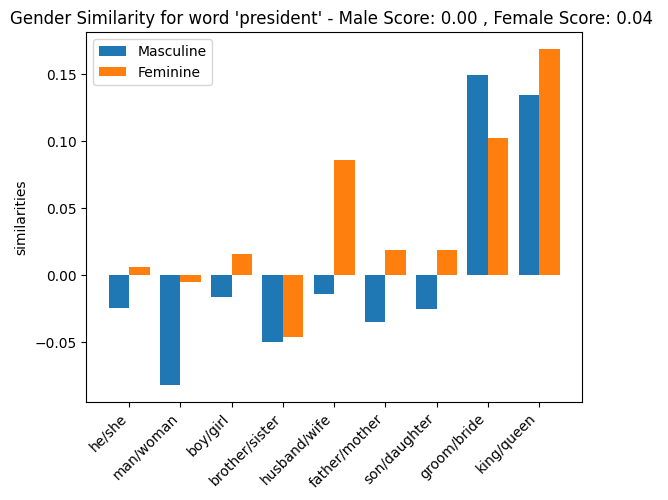

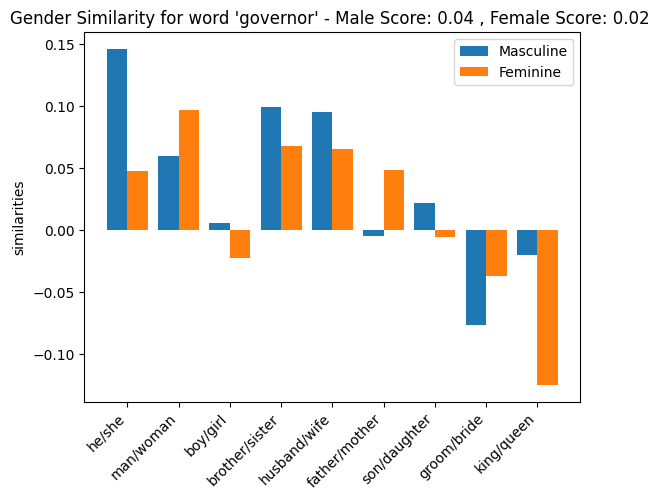

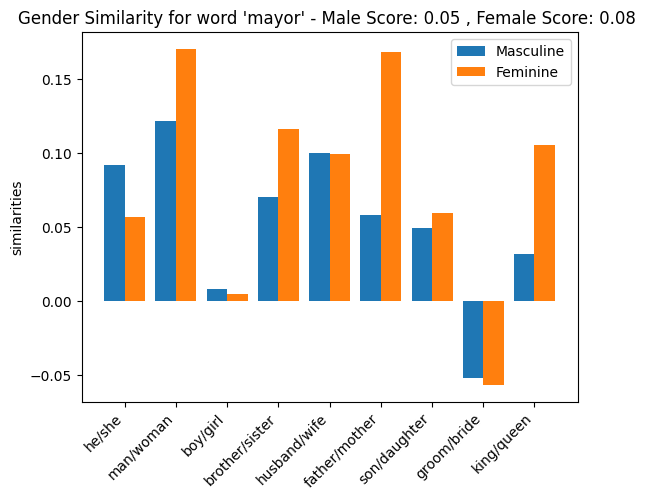

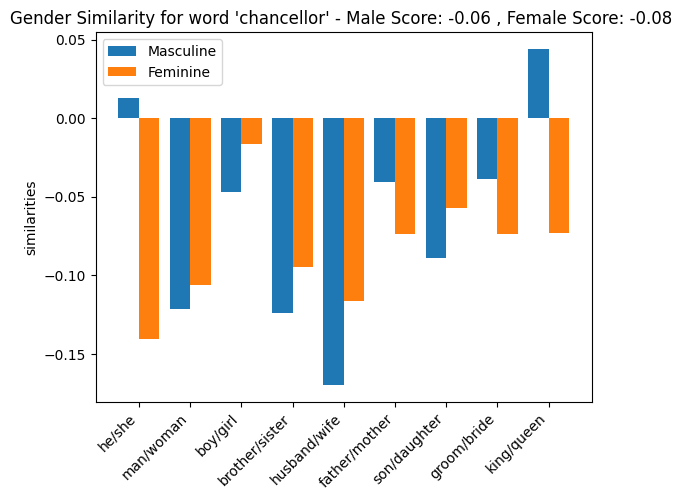

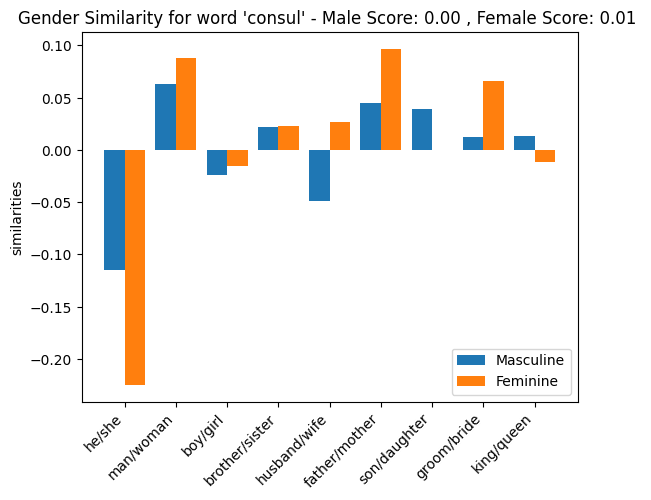

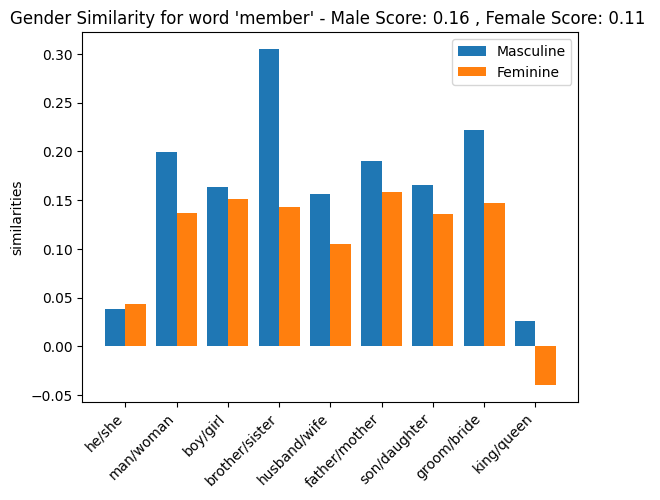

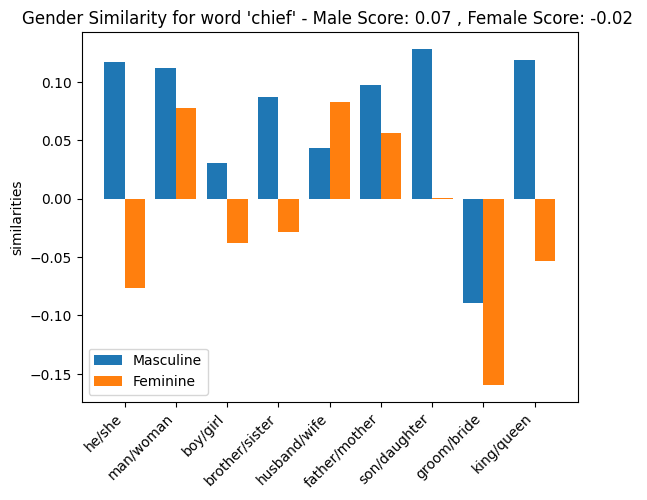

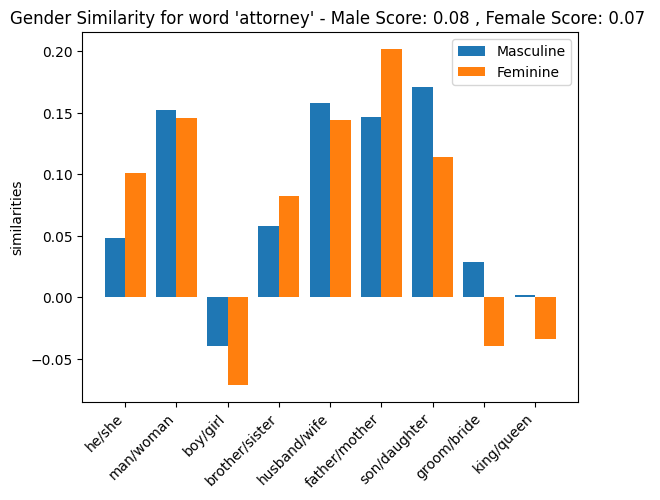

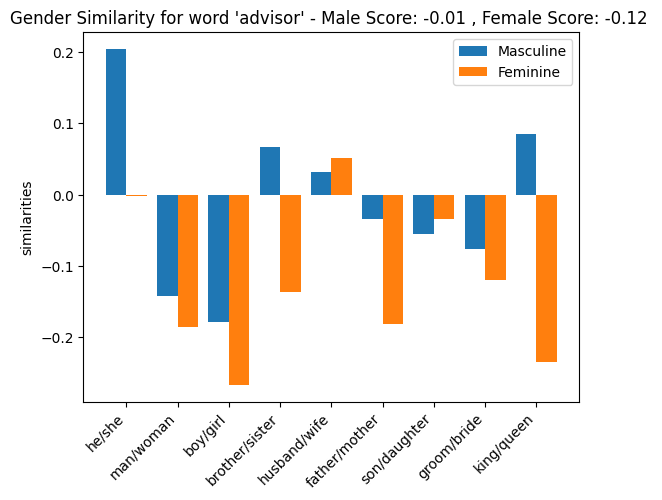

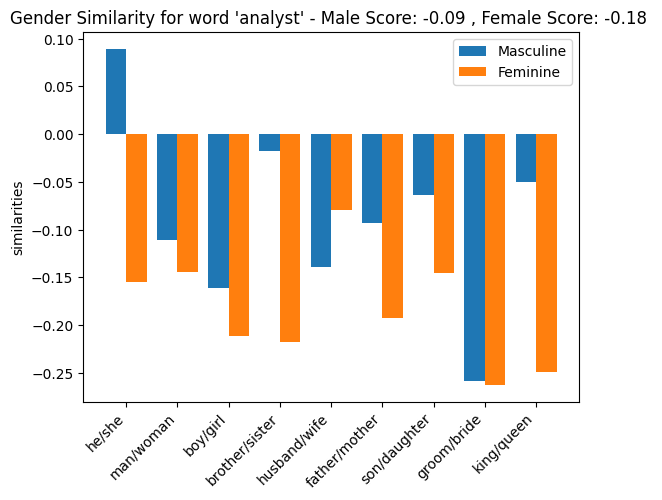

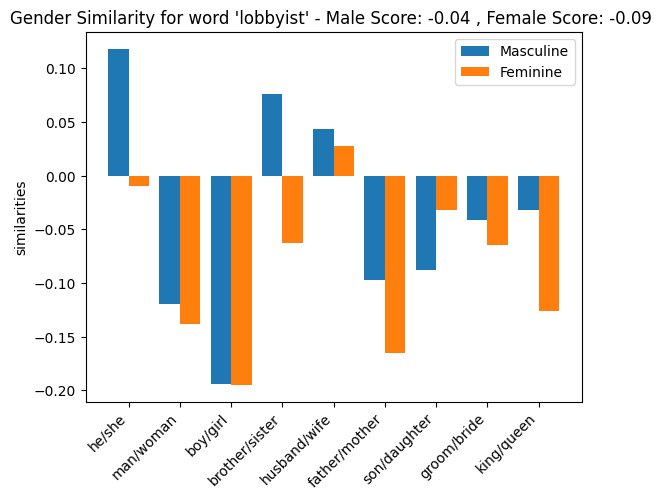

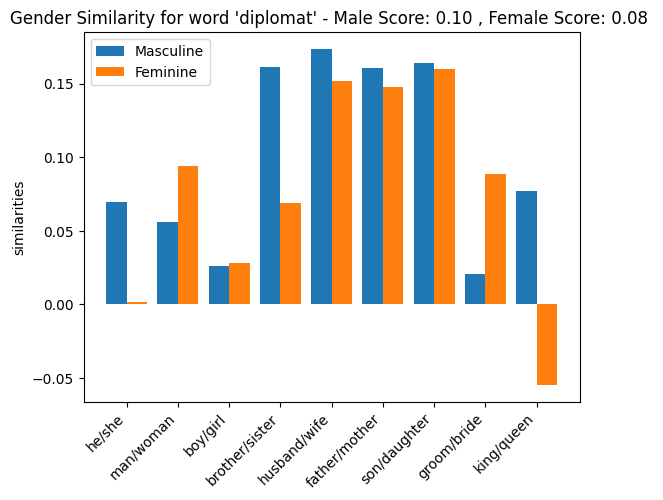

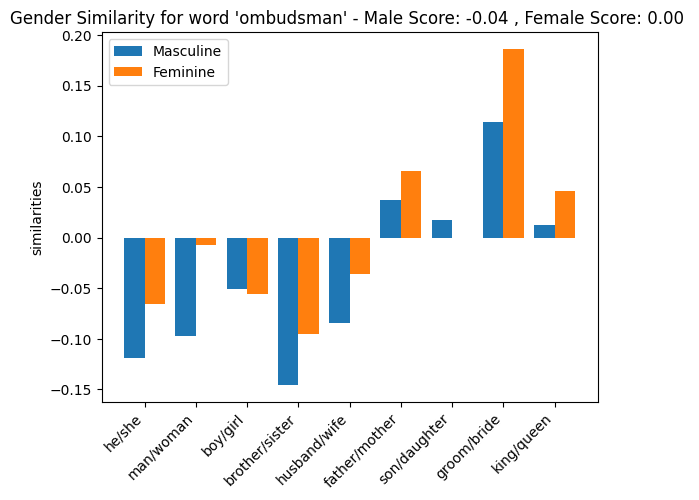

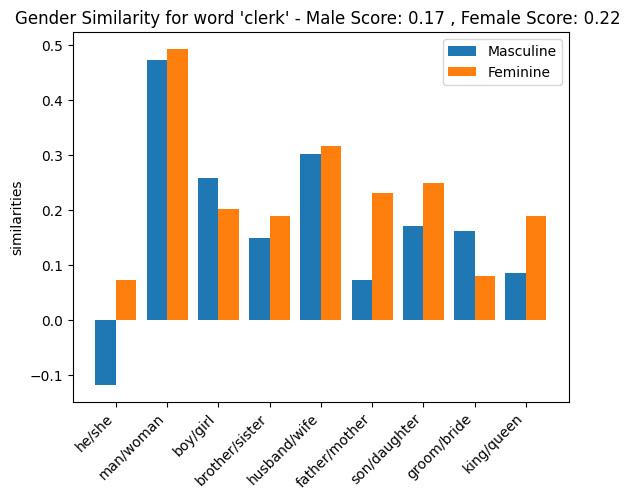

In [20]:
for political_pos in political_positions:
  positions = np.arange(len(male_words))
  plt.bar(positions - 0.2, distance[political_pos][0], width=0.4, label='Masculine')
  plt.bar(positions + 0.2, distance[political_pos][1], width=0.4, label='Feminine')

  labels = [f'{x}/{y}' for x,y in zip(male_words,female_words)]
  plt.xlabel('')
  plt.ylabel('similarities')
  plt.title(f"Gender Similarity for word '{political_pos}' - Male Score: {distance[political_pos][0].mean():.2f} , Female Score: {distance[political_pos][1].mean():.2f} ")
  plt.xticks(positions, labels, rotation=45, ha='right')
  plt.legend()
  plt.show()

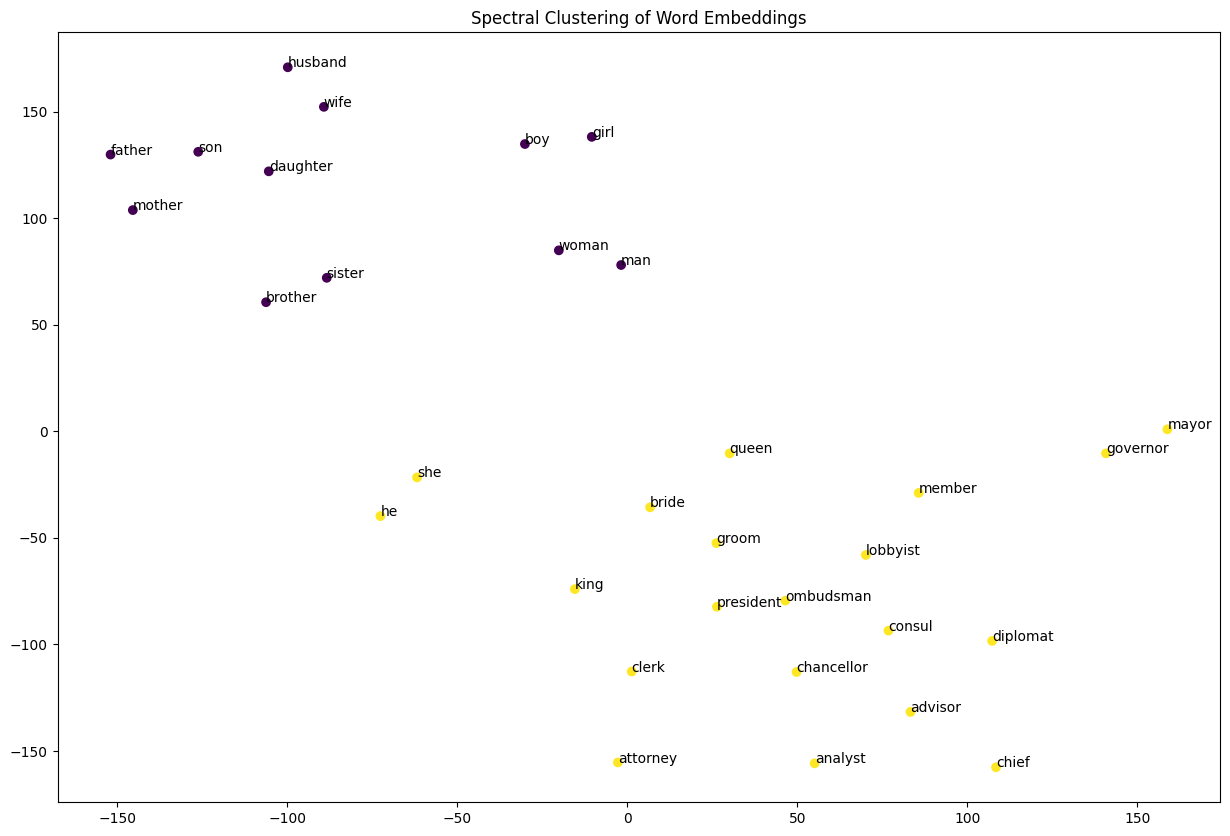

In [21]:
# Select a subset of the embeddings
subset_embeddings = np.array([model.wv[word] for word in political_positions+male_words+female_words])

# Perform spectral clustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral_clustering.fit_predict(subset_embeddings)

# Get the cluster labels
cluster_labels = spectral_clustering.labels_

# Visualize the clusters
tsne = TSNE(n_components=2,perplexity=7)
tsne_embeddings = tsne.fit_transform(subset_embeddings)

plt.figure(figsize = (15,10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.title('Spectral Clustering of Word Embeddings')
# Annotate points with words
for i, word in enumerate(political_positions+male_words+female_words):
    plt.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))

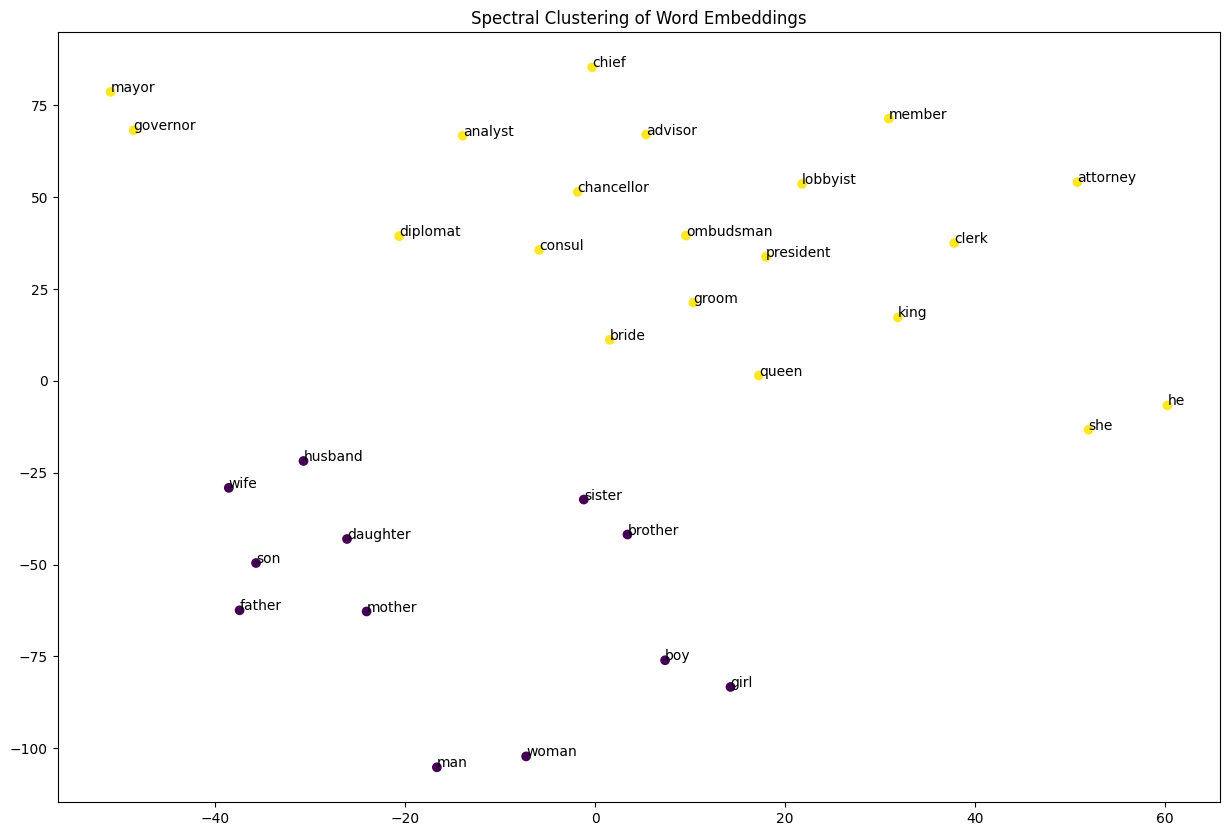

In [22]:
# Visualize the clusters
tsne = TSNE(n_components=2,perplexity=7)
tsne_embeddings = tsne.fit_transform(subset_embeddings)

plt.figure(figsize = (15,10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.title('Spectral Clustering of Word Embeddings')
# Annotate points with words
for i, word in enumerate(political_positions+male_words+female_words):
    plt.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))


plt.show()



In [ ]:
# prompt: connect to gdrive

from google.colab import drive
drive.mount('/content/drive')


In [23]:
male_words= ['he', 'man', 'boy', 'brother', 'husband', 'father', 'son', 'groom', 'king']
female_words= ['she','woman', 'girl', 'sister', 'wife', 'mother', 'daughter', 'bride', 'queen']

political_words = ['populist', 'authoritarian', 'nationalist', 'socialist', 'capitalist', 'anarchist', 'green',
                   'pacifist', 'nationalist', 'feminist', 'secular', 'lobbyist', 'partisan', 'centrist']


political_positions = ['president', 'governor', 'mayor', 'chancellor', 'consul', 'member', 'chief', 'attorney', 'advisor',
                       'analyst', 'lobbyist', 'diplomat', 'ombudsman', 'clerk']


political_viewpoints = [ 'authoritarian', 'globalist', 'capitalist', 'hawkish',]

# Create a list of opposite viewpoints
opposite_viewpoints = [ 'libertarian', 'nationalist', 'socialist', 'pacifist']

In [24]:
# prompt: extract /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz
!gunzip /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz

# Load the Google News model
model2 = word2vec.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)


gzip: /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [29]:
GoogleNews=model2

In [25]:
male_vector = np.array([model2[word] for word in male_words])
female_vector = np.array([model2[word] for word in female_words])

In [26]:
political_vector = np.array([model2[word] for word in political_positions])

from scipy.spatial.distance import cdist
mean_distance_male = np.mean(cdist(political_vector, male_vector,metric='cosine'), axis=1)
mean_distance_female = np.mean(cdist(political_vector, female_vector,metric='cosine'), axis=1)
# mean_distance_male = np.mean(np.linalg.norm(political_vector - male_vector, axis=1))
# mean_distance_female = np.mean(np.linalg.norm(political_vector - female_vector, axis=1))
print("Mean distance to male vector:", mean_distance_male)
print("Mean distance to female vector:", mean_distance_female)

Mean distance to male vector: [0.88032602 0.82873421 0.80931    0.87730686 0.80134752 0.89390966
 0.86830059 0.84916685 0.91128435 0.93975871 0.90395162 0.84047032
 0.93238645 0.78926084]
Mean distance to female vector: [0.9132006  0.82407487 0.82154236 0.86973949 0.77992091 0.89395377
 0.93556602 0.85245075 0.93003556 0.96250054 0.89367827 0.82134016
 0.89603059 0.7197722 ]


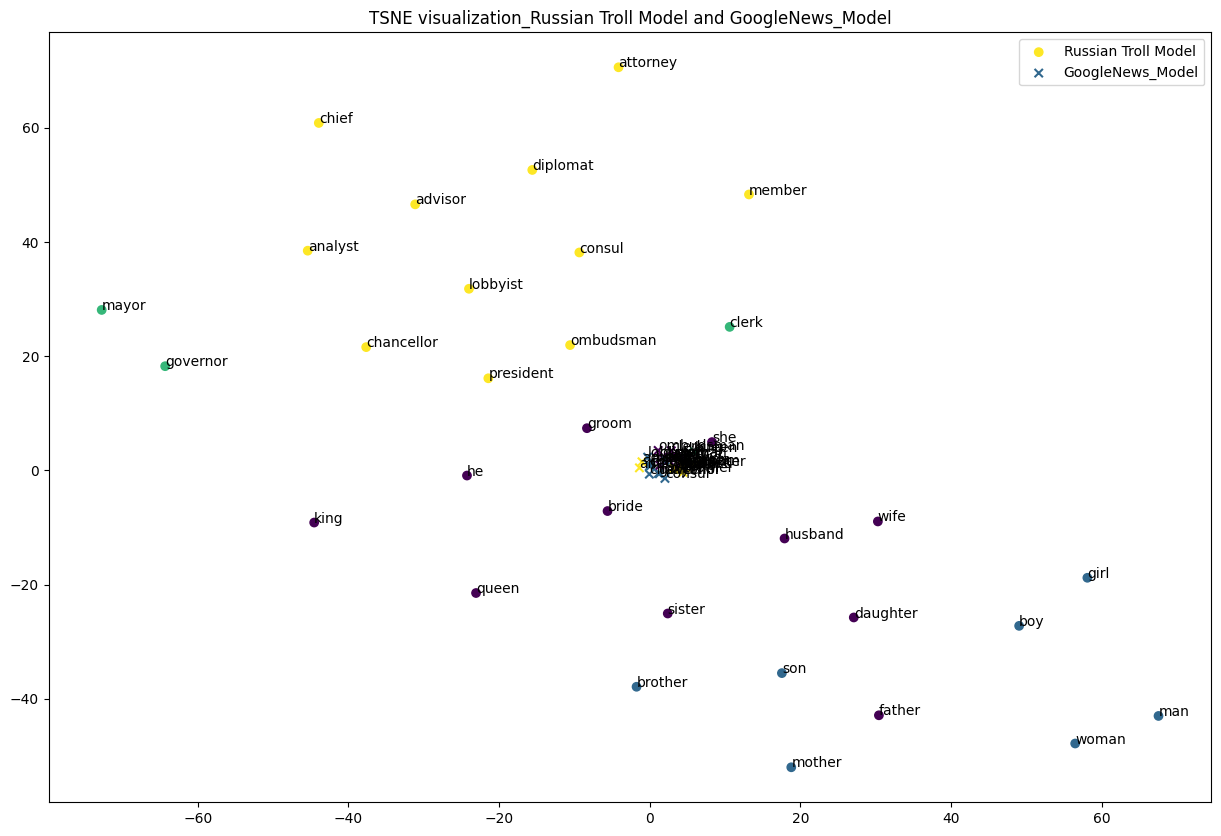

In [59]:
# Select a subset of the embeddings
subset_embeddings_model1 = np.array([model.wv[word] for word in political_positions+male_words+female_words])
subset_embeddings_model2 = np.array([model2[word] for word in political_positions+male_words+female_words])
# Perform spectral clustering
spectral_clustering_1 = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans',random_state=42)
labels_1 = spectral_clustering_1.fit_predict(subset_embeddings_model1)
# Get the cluster labels
cluster_labels_1 = spectral_clustering_1.labels_

spectral_clustering_2 = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans',random_state=42)
labels_2 = spectral_clustering_2.fit_predict(subset_embeddings_model2)

# Get the cluster labels
cluster_labels_2 = spectral_clustering_2.labels_

# Visualize the clusters
tsne_1 = TSNE(n_components=2,perplexity=15,random_state=10)
tsne_embeddings_1 = tsne_1.fit_transform(subset_embeddings_model1)
tsne_2 = TSNE(n_components=2,perplexity=15,random_state=10)
tsne_embeddings_2 = tsne_2.fit_transform(subset_embeddings_model2)

plt.figure(figsize = (15,10))
plt.scatter(tsne_embeddings_1[:, 0], tsne_embeddings_1[:, 1], c=cluster_labels_1,label='Russian Troll Model')
plt.scatter(tsne_embeddings_2[:, 0], tsne_embeddings_2[:, 1], c=cluster_labels_2,marker='x',label='GoogleNews_Model')
plt.title('TSNE visualization_Russian Troll Model and GoogleNews_Model')
# Annotate points with words
for i, word in enumerate(political_positions+male_words+female_words):
    plt.annotate(word, (tsne_embeddings_1[i, 0], tsne_embeddings_1[i, 1]))
    plt.annotate(word, (tsne_embeddings_2[i, 0], tsne_embeddings_2[i, 1]))
plt.legend()

In [28]:
subset_embeddings_model2.shape

(32, 300)